# localization.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

In [166]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn import mixture
import scipy

def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], nb), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

#Create function to save classifier
def saveCLF(clf,path):
    joblib.dump(clf,path)
    
#Create function to load classifier
def loadCLF(path):
    return joblib.load(path)

#Class to hold the feature data and the label
class labeledData():
    def __init__(self,data,label,num):
        self.data = data
        self.label = label
        self.num = num

# ATTEMPTING KMEANS FIRST

In [161]:
#Fetch img
path = './MIO-TCD-Localization/MIO-TCD-Localization/train/00000077.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (400,400))
h,w,c = img.shape
print(img.shape)
#Find the Kmeans of the image
imgK = img.reshape(h*w,c)
kmeans = KMeans(n_clusters=3, random_state=0).fit(imgK)
#GM = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(imgK)

(400, 400, 3)


(400, 400)


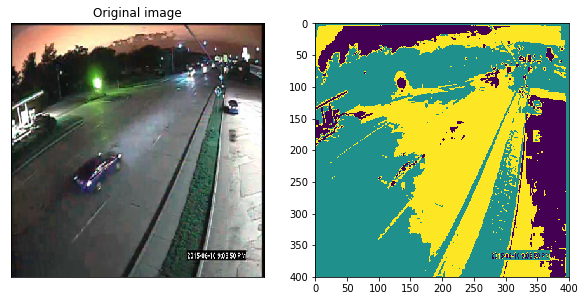

In [162]:
outK = kmeans.labels_.reshape((h,w))
print(outK.shape)

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img)
plt.title("Original image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(outK)

plt.show()

In [163]:
cs = (8,8)
bs = (4,4)
nb = 32

hog = HoGFromImage(img,cs,bs,nb)

error: OpenCV(3.4.3) C:\projects\opencv-python\opencv\modules\objdetect\src\hog.cpp:241: error: (-215:Assertion failed) img.type() == CV_8U || img.type() == CV_8UC3 in function 'cv::HOGDescriptor::computeGradient'


In [148]:
print(hog.shape)

(50, 50, 32)


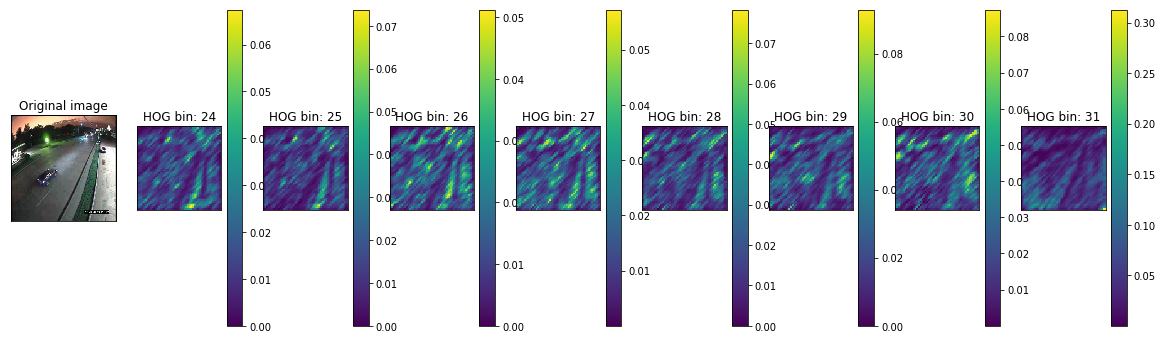

In [151]:
plt.figure(figsize = (20,20))
plt.subplot(191)
plt.imshow(img)
plt.title("Original image"), plt.xticks([]), plt.yticks([])

for bin in range(24,32):
    plt.subplot(192+bin%8)
    plt.pcolor(hog[:, :, bin%nb])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nb)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

In [153]:
#Find what bin the maximum of hog features has been found
maxArr = np.median(np.median(hog,axis=0),axis = 0)
print(np.argmax(maxArr))
print(np.argmax(maxArr)/nb*360)

0
0.0


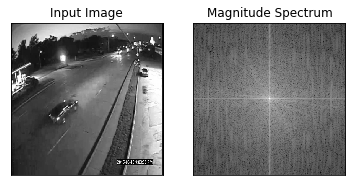

In [203]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
f = np.fft.fft2(gray)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

maxY = np.max(magnitude_spectrum)

In [186]:
print(grad.shape)

(400, 400)


In [187]:
gradMag = np.absolute(grad)

In [188]:
print(gradMag.shape)

(400, 400)


[[0.87448257 0.63642414 1.         ... 0.34285888 0.42553635 0.12594539]
 [0.35998041 0.14261017 0.72680231 ... 0.08703696 0.37842762 0.21418107]
 [0.21635918 0.18553943 0.56045154 ... 0.11921714 0.51155391 0.19839601]
 ...
 [0.14205177 0.17442199 0.25363281 ... 0.14870595 0.1084215  0.48496967]
 [0.21292722 0.19839601 0.51155391 ... 0.11751728 0.56045154 0.18553943]
 [0.61004271 0.21418107 0.37842762 ... 0.58004316 0.72680231 0.14261017]]


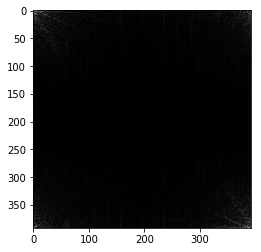

In [201]:
gradMag = gradMag[1:gradMag.shape[1]-1, 1:gradMag.shape[0]-1]
gradMag = gradMag / max(gradMag.reshape(-1))
plt.imshow(gradMag*255,cmap = 'gray' )
print(gradMag)
plt.show()
